# 574 project IV
#### Marley Randazzo • 4/26/23
## Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.patches as mpatches
import os
import pysal as ps
from matplotlib.colors import TwoSlopeNorm
from matplotlib import font_manager as fm
from census import Census
pd.set_option('display.max_columns', None)

# import custom font
fpath = os.path.join('/Users/marley/Library/Fonts/HelveticaNeue-Roman.otf')
prop = fm.FontProperties(fname=fpath, size=10)
fname = os.path.split(fpath)[1] 

def mapspines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

In [2]:
# define categorical variables with dictionaries
rural_continuum = {1 : 'Counties in metro areas of 1 million population or more',
                   2 : 'Counties in metro areas of 250,000 to 1 million population',
                   3 : 'Counties in metro areas of fewer than 250,000 population',
                   4 : 'Urban population of 20,000 or more, adjacent to a metro area',
                   5 : 'Urban population of 20,000 or more, not adjacent to a metro area',
                   6 : 'Urban population of 2,500 to 19,999, adjacent to a metro area',
                   7 : 'Urban population of 2,500 to 19,999, not adjacent to a metro area',
                   8 : 'Completely rural or less than 2,500 urban population, adjacent to a metro area',
                   9 : 'Completely rural or less than 2,500 urban population, not adjacent to a metro area'}

urban_influence = {1 : 'In large metro area of 1+ million residents',
                   2 : 'In small metro area of less than 1 million residents',
                   3 : 'Micropolitan area adjacent to large metro area',
                   4 : 'Noncore adjacent to large metro area',
                   5 : 'Micropolitan area adjacent to small metro area',
                   6 : 'Noncore adjacent to small metro area and contains a town of at least 2,500 residents',
                   7 : 'Noncore adjacent to small metro area and does not contain a town of at least 2,500 residents',
                   8 : 'Micropolitan area not adjacent to a metro area',
                   9 : 'Noncore adjacent to micro area and contains a town of at least 2,500 residents',
                  10 : 'Noncore adjacent to micro area and does not contain a town of at least 2,500 residents',
                  11 : 'Noncore not adjacent to metro or micro area and contains a town of at least 2,500 residents',
                  12 : 'Noncore not adjacent to metro or micro area and does not contain a town of at least 2,500 residents'}

Census pop data:
* 2020–2022: https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html
* 2010-2019: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html

## Load & process data

In [3]:
# begin w 2010–2019
url = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv'
d_2019 = pd.read_csv(url,encoding='ISO-8859-1')

# create FIPS col and set index
d_2019.loc[:,'STATE'] = d_2019.STATE.astype(str).str.zfill(2)
d_2019.loc[:,'COUNTY'] = d_2019.COUNTY.astype(str).str.zfill(3)
d_2019.loc[:,'FIPS'] = d_2019.STATE + d_2019.COUNTY
d_2019.FIPS = d_2019.FIPS.astype(str)
d_2019.set_index('FIPS',inplace=True)

# retain just 2019 numbers
cols = ['STNAME','CTYNAME',] + list(d_2019.filter(regex='20').columns)
d_2019 = d_2019[cols]
d_2019.shape

(3193, 159)

In [4]:
# grab most recent Census pop & migration estimates 2020–2022
url = 'https://www2.census.gov/programs-surveys/popest/datasets/2020-2022/counties/totals/co-est2022-alldata.csv'
d = pd.read_csv(url)

d.loc[:,'STATE'] = d.STATE.astype(str).str.zfill(2)
d.loc[:,'COUNTY'] = d.COUNTY.astype(str).str.zfill(3)
d.loc[:,'FIPS'] = d.STATE + d.COUNTY
d.set_index('FIPS',inplace=True)
d.drop('ESTIMATESBASE2020',axis=1,inplace=True)

In [5]:
# merge 2010–2019 & 2020–2022 data
d10_22 = d_2019.merge(d,how='outer',left_index=True,right_index=True)

# check to see unmerged counties
print(d10_22[d10_22.CTYNAME_x.isna()][['STNAME_y','CTYNAME_y']])

          STNAME_y                                      CTYNAME_y
FIPS                                                             
02063       Alaska                            Chugach Census Area
02066       Alaska                       Copper River Census Area
09110  Connecticut                        Capitol Planning Region
09120  Connecticut             Greater Bridgeport Planning Region
09130  Connecticut  Lower Connecticut River Valley Planning Regio
09140  Connecticut               Naugatuck Valley Planning Region
09150  Connecticut       Northeastern Connecticut Planning Region
09160  Connecticut                Northwest Hills Planning Region
09170  Connecticut      South Central Connecticut Planning Region
09180  Connecticut       Southeastern Connecticut Planning Region
09190  Connecticut            Western Connecticut Planning Region


N.B.: Connecticut's counties changed to planning regions in 2022
- most recent metro/micro classifications are from 2020
- all now-defunct counties were metro except for Licthfield county which is micropolitan, now Northwest Hills

In [6]:
# clean col names to reorganize dataframe
d10_22.columns = d10_22.columns.str.replace('NATURALINC','NATURALCHG')
cols = ['POPESTIMATE','DOMESTICMIG','INTERNATIONALMIG','NETMIG','NATURALCHG']
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
emp_list = []
for col in cols:
    for year in years:
        emp_list.append(d10_22[col+year])
dx = pd.concat(emp_list,axis=1)
d = pd.concat([d10_22[['STNAME_x','CTYNAME_x','STNAME_y','CTYNAME_y']],dx],axis=1)
d[(d.STNAME_x.isna())&~(d.STNAME_y.isna())]

# merge state name and county cols to accommodate CT and AK counties
d.loc[:,'state'] = d.STNAME_x
d.loc[:,'county'] = d.CTYNAME_x
d.loc[d.state.isna(),'state'] = d.STNAME_y
d.loc[d.county.isna(),'county'] = d.CTYNAME_y
d = d[d.columns[-2:].tolist() + d.columns[4:-2].tolist()]
print(len(d[d.state.isna()]), 'null counties')

0 null counties


In [7]:
# load OMB census metro and micro statistical area delineations
temp = pd.read_csv('../../574/census_delineations/cd_2020.csv')
temp.dropna(subset='County/County Equivalent',inplace=True)

# set FIPS and drop PR
temp.loc[:,'FIPS'] = temp['FIPS State Code'].astype(int).astype(str).str.zfill(2) + temp['FIPS County Code'].astype(int).astype(str).str.zfill(3)
temp.set_index('FIPS',inplace=True)
temp = temp.loc[temp.index.str[0]!='7']
        
# create geo col and clean cols
temp.loc[:,'geo'] = temp['Metropolitan/Micropolitan Statistical Area'].str[:5].str.lower()
temp.drop(['CBSA Code','Metropolitan Division Code','CSA Code','Metropolitan/Micropolitan Statistical Area','FIPS State Code','FIPS County Code'],axis=1,inplace=True)
temp.columns = temp.columns.str.lower().str.replace(' ','_')
temp.rename(columns={'component_name':'county',
                     'metropolitan_division_title':'metro_div',
                     'central/outlying_county':'county_status',
                     'county/county_equivalent':'county',
                     'state_name':'state'},inplace=True)
temp.county_status = temp.county_status.str.lower()
temp = temp[['geo','county_status','cbsa_title','csa_title']].sort_index()
temp.sample(5)

,geo,county_status,cbsa_title,csa_title
FIPS,,,,
25015,metro,central,"Springfield, MA",NaN
41071,metro,outlying,"Portland-Vancouver-Hillsboro, OR-WA","Portland-Vancouver-Salem, OR-WA"
47119,metro,outlying,"Nashville-Davidson--Murfreesboro--Franklin, TN","Nashville-Davidson--Murfreesboro, TN"
28051,metro,outlying,"Jackson, MS","Jackson-Vicksburg-Brookhaven, MS"
51085,metro,central,"Richmond, VA",NaN


In [8]:
# load USDA typology codes and rural continuum and urban influence codes
usda = pd.read_csv('../../574/usda_typology_codes_2015.csv')
usda = usda.merge(pd.read_csv('usda_unemployment.csv'), how='left', left_on='FIPStxt', right_on='FIPS_code')
usda.loc[:,'FIPStxt'] = usda.FIPStxt.astype(str).str.zfill(5)
usda.set_index('FIPStxt',inplace=True)
codes = usda[['Rural_urban_continuum_code_2013','Urban_influence_code_2013','Farming_2015_Update',
              'Mining_2015-Update','Manufacturing_2015_Update','Government_2015_Update',
              'Recreation_2015_Update','Retirement_Dest_2015_Update','Nonspecialized_2015_Update',]]

codes.columns = ['rural_continuum','urban_influence','farm_d','mining_d','manu_d','gov_d','rec_d','retire_d','nonspec_d']
codes

,rural_continuum,urban_influence,farm_d,mining_d,manu_d,gov_d,rec_d,retire_d,nonspec_d
FIPStxt,,,,,,,,,
01001,2.0,2.0,0,0,0,0,0,1,1
01003,3.0,2.0,0,0,0,0,1,1,0
01005,6.0,6.0,0,0,1,0,0,0,0
01007,1.0,1.0,0,0,0,0,0,0,1
01009,1.0,1.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
56037,5.0,8.0,0,1,0,0,0,0,0
56039,7.0,8.0,0,0,0,0,1,0,0
56041,7.0,8.0,0,1,0,0,0,0,0


In [9]:
# merge census pop data and OMB delineations
df = d.merge(temp,how='left',left_index=True,right_index=True)

# re-order cols
df = df[df.columns[:2].tolist() + df.columns[-4:].tolist() + df.columns[2:-4].tolist()]

# drop state totals
df = df[df.index.str[-3:]!='000']

# merge with USDA codes
df = df.merge(codes,how='left',left_index=True,right_index=True)

# manually add CT planning region geo and county status
df.loc[(df.state=='Connecticut')&(df.geo.isna()),'county_status'] = 'central'
df.loc[(df.state=='Connecticut')&(df.geo.isna()),'geo'] = 'metro'
df.loc['09160','geo'] = 'micro'

# assign NA geos rural
#df.loc[df.geo.isna(),'geo'] = 'rural'

df.sample(5)

,state,county,geo,county_status,cbsa_title,csa_title,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,DOMESTICMIG2010,DOMESTICMIG2011,DOMESTICMIG2012,DOMESTICMIG2013,DOMESTICMIG2014,DOMESTICMIG2015,DOMESTICMIG2016,DOMESTICMIG2017,DOMESTICMIG2018,DOMESTICMIG2019,DOMESTICMIG2020,DOMESTICMIG2021,DOMESTICMIG2022,INTERNATIONALMIG2010,INTERNATIONALMIG2011,INTERNATIONALMIG2012,INTERNATIONALMIG2013,INTERNATIONALMIG2014,INTERNATIONALMIG2015,INTERNATIONALMIG2016,INTERNATIONALMIG2017,INTERNATIONALMIG2018,INTERNATIONALMIG2019,INTERNATIONALMIG2020,INTERNATIONALMIG2021,INTERNATIONALMIG2022,NETMIG2010,NETMIG2011,NETMIG2012,NETMIG2013,NETMIG2014,NETMIG2015,NETMIG2016,NETMIG2017,NETMIG2018,NETMIG2019,NETMIG2020,NETMIG2021,NETMIG2022,NATURALCHG2010,NATURALCHG2011,NATURALCHG2012,NATURALCHG2013,NATURALCHG2014,NATURALCHG2015,NATURALCHG2016,NATURALCHG2017,NATURALCHG2018,NATURALCHG2019,NATURALCHG2020,NATURALCHG2021,NATURALCHG2022,rural_continuum,urban_influence,farm_d,mining_d,manu_d,gov_d,rec_d,retire_d,nonspec_d
FIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48095,Texas,Concho County,NaN,NaN,NaN,NaN,4102.0,4124.0,4085.0,4122.0,4089.0,4072.0,4140.0,2707.0,2683.0,2726.0,3303.0,3336.0,3340.0,10.0,-5.0,-91.0,34.0,-59.0,-57.0,35.0,-1482.0,-50.0,22.0,1.0,41.0,-2.0,1.0,29.0,48.0,22.0,35.0,40.0,43.0,35.0,26.0,26.0,0.0,8.0,23.0,11.0,24.0,-43.0,56.0,-24.0,-17.0,78.0,-1447.0,-24.0,48.0,1.0,49.0,21.0,4.0,-3.0,2.0,-21.0,-10.0,-1.0,-11.0,-7.0,0.0,-5.0,2.0,-15.0,-15.0,8.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16073,Idaho,Owyhee County,metro,outlying,"Boise City, ID","Boise City-Mountain Home-Ontario, ID-OR",11473.0,11376.0,11409.0,11394.0,11288.0,11288.0,11364.0,11618.0,11669.0,11823.0,11994.0,12348.0,12613.0,-61.0,-130.0,-31.0,-87.0,-157.0,-43.0,16.0,209.0,18.0,110.0,79.0,366.0,270.0,1.0,3.0,4.0,27.0,-3.0,7.0,6.0,-6.0,-5.0,-5.0,0.0,2.0,6.0,-60.0,-127.0,-27.0,-60.0,-160.0,-36.0,22.0,203.0,13.0,105.0,79.0,368.0,276.0,3.0,30.0,61.0,44.0,52.0,39.0,54.0,51.0,38.0,47.0,6.0,-2.0,-14.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20129,Kansas,Morton County,NaN,NaN,NaN,NaN,3240.0,3176.0,3127.0,3116.0,3041.0,2953.0,2790.0,2747.0,2693.0,2587.0,2697.0,2669.0,2599.0,-8.0,-57.0,-56.0,-34.0,-61.0,-73.0,-151.0,-52.0,-76.0,-116.0,3.0,-17.0,-71.0,3.0,5.0,-3.0,-4.0,-4.0,2.0,4.0,1.0,3.0,-2.0,0.0,3.0,10.0,-5.0,-52.0,-59.0,-38.0,-65.0,-71.0,-147.0,-51.0,-73.0,-118.0,3.0,-14.0,-61.0,12.0,-13.0,9.0,26.0,-11.0,-19.0,-15.0,7.0,18.0,12.0,-2.0,-13.0,-13.0,9.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
01103,Alabama,Morgan County,metro,central,"Decatur, AL","Huntsville-Decatur, AL",119608.0,120024.0,120102.0,119571.0,119444.0,119257.0,119006.0,118918.0,119203.0,119679.0,123288.0,123403.0,124211.0,26.0,19.0,-159.0,-702.0,-377.0,-391.0,-536.0,-328.0,130.0,285.0,-99.0,366.0,1032.0,18.0,137.0,74.0,11.0,80.0,111.0,215.0,105.0,148.0,113.0,1.0,18.0,27.0,44.0,156.0,-85.0,-691.0,-297.0,-280.0,-321.0,-223.0,278.0,398.0,-98.0,384.0,1059.0,90.0,264.0,183.0,161.0,177.0,102.0,71.0,137.0,13.0,86.0,-39.0,-356.0,-239.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17165,Illinois,Saline County,NaN,NaN,NaN,NaN,24902.0,24907.0,24914.0,24803.0,24496.0,24495.0,24230.0,23963.0,23789.0,23491.0,23688.0,23348.0,23087.0,33.0,46.0,15.0,-69.0,-252.0,-8.0,-229.0,-155.0,-110.0,-231.0,-62.0,-186.0,-92.0,2.0,7.0,6.0,3.0,2.0,0.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,-1.0,35.0,53.0,21.0,-66.0,-250.0,-8.0,-231.0,-157.0,-112.0,-233.0,-62.0,-186.0,-93.0,-47.0,-47.0,-10.0,-42.0,-60.0,11.0,-34.0,-109.0,-62.0,-65.0,-16.0,-158.0,-160.0,6.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## EDA

In [10]:
# summary stats for domestic migration rate variable
z = df.filter(regex='DOM').div((df.filter(regex='POP').values * .001))
z.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
DOMESTICMIG2010,3142.0,-0.08,5.13,-235.22,-1.22,-0.03,1.11,44.35
DOMESTICMIG2011,3142.0,-1.78,10.23,-131.78,-6.25,-1.84,2.65,115.79
DOMESTICMIG2012,3142.0,-2.78,11.64,-105.68,-7.79,-2.76,2.36,112.18
DOMESTICMIG2013,3142.0,-1.76,11.75,-116.21,-6.78,-1.99,3.09,188.68
DOMESTICMIG2014,3142.0,-1.97,11.19,-191.01,-7.24,-2.09,3.27,138.36
DOMESTICMIG2015,3142.0,-1.79,12.26,-102.16,-7.33,-2.10,3.78,243.70
DOMESTICMIG2016,3142.0,-1.46,13.10,-130.88,-7.43,-1.76,4.54,188.85
DOMESTICMIG2017,3142.0,-0.39,16.25,-547.47,-6.61,-0.47,6.73,142.86
DOMESTICMIG2018,3142.0,-0.11,11.64,-76.73,-6.31,-0.55,6.05,67.57
DOMESTICMIG2019,3142.0,-0.45,12.57,-180.44,-6.05,-0.77,5.40,118.34


Pre-pandemic, counties were on average experiencing domestic outmigration of 1-3 people per thousand. After the pandemic, the mean values grow from 3 to 5.

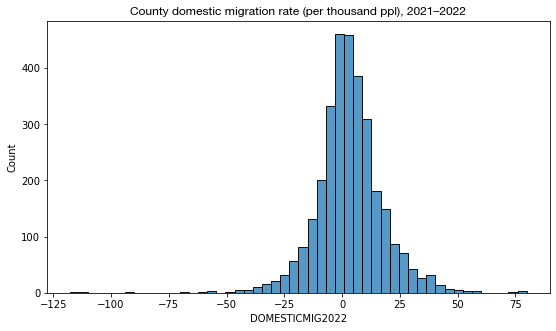

In [11]:
# plot a histogram of the 2022 domestic migration rate
fig,ax=plt.subplots(figsize=(9,5))
sns.histplot(data=z.DOMESTICMIG2022,ax=ax,bins=50)
plt.title(label='County domestic migration rate (per thousand ppl), 2021–2022',fontproperties=prop,fontsize=12)
plt.show()
fig.savefig('Y_hist.png', dpi=600, bbox_inches='tight')

Variable is normally distributed.

In [12]:
# assess domestic migration by rural continuum code

domestic_mig_cols = df.filter(regex='DOMESTIC').columns.tolist()
popestimate_cols = df.filter(regex='POPESTIMATE').columns.tolist()

u = df.groupby('rural_continuum')[domestic_mig_cols].sum()
p = df.groupby('rural_continuum')[popestimate_cols].sum()
u = u / (p.values *.001)
u.index = u.index.map(rural_continuum)
u.T.round(3)

rural_continuum,Counties in metro areas of 1 million population or more,"Counties in metro areas of 250,000 to 1 million population","Counties in metro areas of fewer than 250,000 population","Urban population of 20,000 or more, adjacent to a metro area","Urban population of 20,000 or more, not adjacent to a metro area","Urban population of 2,500 to 19,999, adjacent to a metro area","Urban population of 2,500 to 19,999, not adjacent to a metro area","Completely rural or less than 2,500 urban population, adjacent to a metro area","Completely rural or less than 2,500 urban population, not adjacent to a metro area"
DOMESTICMIG2010,-0.138,0.404,0.345,-0.140,-0.065,-0.494,-0.375,-0.216,0.044
DOMESTICMIG2011,0.198,1.040,0.001,-1.668,-1.160,-2.809,-2.421,-3.316,-2.219
DOMESTICMIG2012,0.680,0.468,0.163,-2.433,-1.892,-4.242,-3.403,-4.855,-3.786
DOMESTICMIG2013,0.568,0.623,-0.379,-3.360,-1.410,-3.011,-2.801,-1.962,-2.168
DOMESTICMIG2014,0.366,0.950,-0.059,-2.518,-2.694,-2.795,-3.792,-1.261,-1.629
DOMESTICMIG2015,0.055,1.546,0.012,-1.939,-2.618,-2.553,-3.679,-0.951,-2.538
DOMESTICMIG2016,-0.399,2.286,0.451,-0.779,-3.359,-1.365,-5.378,-0.776,-2.239
DOMESTICMIG2017,-0.943,2.459,1.517,0.491,-4.606,0.565,-4.531,1.763,-1.242
DOMESTICMIG2018,-1.204,2.394,2.180,0.578,-2.969,0.675,-2.219,3.146,-1.575
DOMESTICMIG2019,-1.093,2.604,1.080,0.770,-1.756,0.264,-2.504,1.572,-1.375


Counties in large metro areas appear to see an outflow of domestic migration beginning in 2016. After the pandemic the declines increase sharply. Rural small counties adjacent to metro areas seem to have the inverse pattern: outflows before 2016, large inflows after the pandemic. 

In [13]:
# assess domestic migration by urban influence code
u = df.groupby('urban_influence')[domestic_mig_cols].sum()
p = df.groupby('urban_influence')[popestimate_cols].sum()
u = u / (p.values *.001)
u.index = u.index.map(urban_influence)
u.T.round(3)

urban_influence,In large metro area of 1+ million residents,In small metro area of less than 1 million residents,Micropolitan area adjacent to large metro area,Noncore adjacent to large metro area,Micropolitan area adjacent to small metro area,"Noncore adjacent to small metro area and contains a town of at least 2,500 residents","Noncore adjacent to small metro area and does not contain a town of at least 2,500 residents",Micropolitan area not adjacent to a metro area,"Noncore adjacent to micro area and contains a town of at least 2,500 residents","Noncore adjacent to micro area and does not contain a town of at least 2,500 residents","Noncore not adjacent to metro or micro area and contains a town of at least 2,500 residents","Noncore not adjacent to metro or micro area and does not contain a town of at least 2,500 residents"
DOMESTICMIG2010,-0.138,0.386,-0.159,-0.944,-0.282,-0.187,-0.598,-0.155,-0.323,-0.216,-0.349,-0.063
DOMESTICMIG2011,0.198,0.727,-1.850,-2.650,-2.308,-2.482,-3.455,-1.550,-2.559,-3.152,-2.763,-1.144
DOMESTICMIG2012,0.680,0.377,-2.838,-5.603,-2.535,-4.200,-5.456,-2.175,-3.965,-3.214,-4.199,-4.964
DOMESTICMIG2013,0.568,0.322,-2.499,-1.924,-3.701,-3.396,-2.483,-1.646,-2.952,-2.155,-3.710,-3.116
DOMESTICMIG2014,0.366,0.647,-1.339,-1.317,-3.303,-3.286,-2.155,-2.650,-3.691,-2.775,-5.389,-1.099
DOMESTICMIG2015,0.055,1.088,-0.701,-0.142,-2.862,-3.359,-2.641,-2.985,-2.475,-3.113,-4.973,-3.076
DOMESTICMIG2016,-0.399,1.739,0.752,0.297,-1.880,-1.915,-2.502,-4.193,-4.464,-4.105,-5.655,-0.872
DOMESTICMIG2017,-0.943,2.179,2.274,4.411,-0.636,-0.789,0.457,-4.587,-3.662,-2.339,-5.260,0.648
DOMESTICMIG2018,-1.204,2.331,2.164,4.079,-0.420,-0.132,0.721,-2.701,-1.806,-1.196,-3.375,-0.136
DOMESTICMIG2019,-1.093,2.152,2.149,2.655,-0.265,-0.542,0.173,-1.763,-2.653,-1.240,-3.592,-1.485


Very similar patterns to rural continuum code, but not quite the same splits so difficult to compare.

## Load spatial data

In [14]:
# load state, us boundary, and county shapefiles
states = gpd.read_file('../../processed_shp/us_state_boundary/')
usa = gpd.read_file('../../processed_shp/us_boundary/')
gdf_ct = gpd.read_file('../../ECH Book/BLS/GIS Data/usa_census_counties_2018_20m/',)

# set FIPS as index, drop HI, AK, and PR, drop extra cols
gdf_ct.loc[:,'FIPS'] = gdf_ct.GEOID.astype(str).str.zfill(5)
gdf_ct = gdf_ct.set_index('FIPS')
mask_non_continental = ((gdf_ct['STATEFP'] == '02') | (gdf_ct['STATEFP'] == '15') | (gdf_ct['STATEFP'] == '72'))
gdf_ct = gdf_ct[~mask_non_continental].sort_index()
gdf_ct.drop(['STATEFP','COUNTYFP','COUNTYNS','AFFGEOID','NAME','LSAD','AWATER','GEOID'],axis=1,inplace=True)

# set CRS
gdf_ct = gdf_ct.to_crs(epsg=5070)
states = states.to_crs(epsg=5070)
usa = usa.to_crs(epsg=5070)

In [15]:
# MAKE GDF: merge FIPS and county GDF
gdf = gdf_ct.merge(df,how='left',left_index=True,right_index=True)

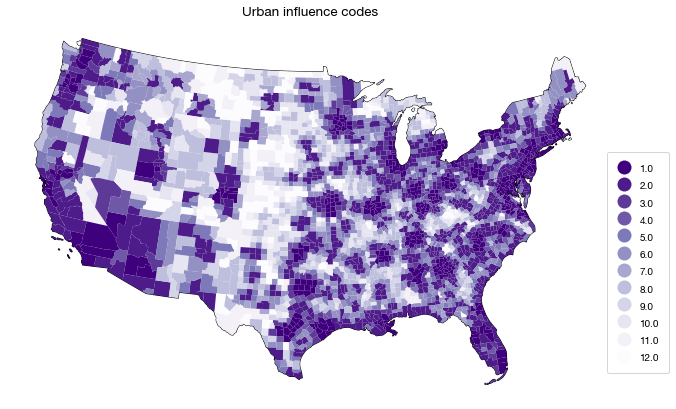

In [16]:
# plot urban influence codes
fig,ax = plt.subplots(figsize=(14,7),nrows=1)
usa.plot(ax=ax,color='white',edgecolor='black')
gdf.plot(ax=ax,column='urban_influence',categorical=True,cmap='Purples_r',edgecolor='None',
         legend=True,legend_kwds={'bbox_to_anchor':[1.1, .67],'markerscale':1.4,'borderpad':1,
                                  'handleheight':1.5,'handlelength':1.5,'prop':prop,})
mapspines(ax)
plt.title(label='Urban influence codes',fontproperties=prop,fontsize=13.5)
plt.show()

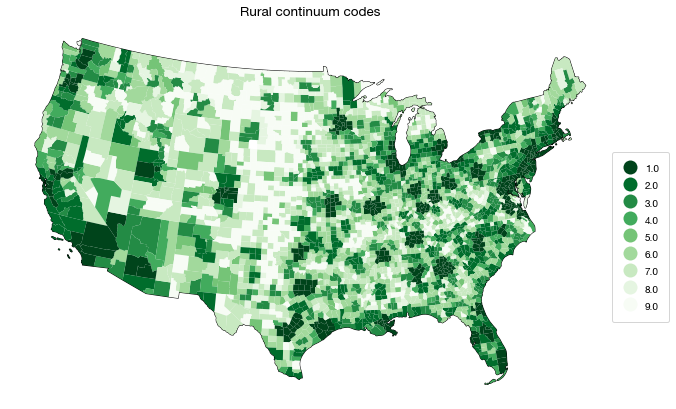

In [17]:
# plot rural continuum codes
fig,ax = plt.subplots(figsize=(14,7),nrows=1)
usa.plot(ax=ax,color='white',edgecolor='black')
gdf.plot(ax=ax,column='rural_continuum',categorical=True,cmap='Greens_r',edgecolor='None',
         legend=True,legend_kwds={'bbox_to_anchor':[1.1, .67],'markerscale':1.4,'borderpad':1,
                                  'handleheight':1.5,'handlelength':1.5,'prop':prop,})
mapspines(ax)
plt.title(label='Rural continuum codes',fontproperties=prop,fontsize=13.5)
plt.show()

In [18]:
# create domestic migration per thousand pop variables for analysis
gdf.loc[:,'DOMMIG2019_THOU'] =  gdf.DOMESTICMIG2019 / (gdf.POPESTIMATE2019*.001)
gdf.loc[:,'DOMMIG2020_THOU'] =  gdf.DOMESTICMIG2020 / (gdf.POPESTIMATE2020*.001)
gdf.loc[:,'DOMMIG2021_THOU'] =  gdf.DOMESTICMIG2021 / (gdf.POPESTIMATE2021*.001)
gdf.loc[:,'DOMMIG2022_THOU'] =  gdf.DOMESTICMIG2022 / (gdf.POPESTIMATE2022*.001)

In [19]:
# check on high growth counties 
col = 'DOMMIG2022_THOU'
gdf.sort_values(by=col,ascending=False).dropna(subset=col)[['county','state','county_status',col,'cbsa_title','urban_influence']].head(10)

,county,state,county_status,DOMMIG2022_THOU,cbsa_title,urban_influence
FIPS,,,,,,
12119,Sumter County,Florida,central,79.857902,"The Villages, FL",2.0
21143,Lyon County,Kentucky,NaN,77.024503,NaN,9.0
53075,Whitman County,Washington,central,76.314076,"Pullman, WA",5.0
08111,San Juan County,Colorado,NaN,74.719801,NaN,10.0
48257,Kaufman County,Texas,outlying,73.268510,"Dallas-Fort Worth-Arlington, TX",1.0
12045,Gulf County,Florida,NaN,58.965652,NaN,2.0
30065,Musselshell County,Montana,NaN,58.687704,NaN,7.0
13183,Long County,Georgia,outlying,58.643994,"Hinesville, GA",2.0
30007,Broadwater County,Montana,NaN,56.075966,NaN,10.0


The Villages, a massive retirement community, leads the nation in domestic migration rate.

In [20]:
# check on high outflow counties 
col = 'DOMMIG2022_THOU'
gdf.sort_values(by=col,ascending=True).dropna(subset=col)[['county','state','county_status',col,'cbsa_title','urban_influence']].head(10)

,county,state,county_status,DOMMIG2022_THOU,cbsa_title,urban_influence
FIPS,,,,,,
48301,Loving County,Texas,outlying,-117.647059,"Pecos, TX",12.0
48269,King County,Texas,NaN,-111.587983,NaN,12.0
13259,Stewart County,Georgia,outlying,-91.437177,"Columbus, GA-AL",6.0
06035,Lassen County,California,central,-69.990637,"Susanville, CA",8.0
13309,Wheeler County,Georgia,NaN,-61.936013,NaN,9.0
31091,Hooker County,Nebraska,NaN,-61.224490,NaN,12.0
48033,Borden County,Texas,NaN,-58.119658,NaN,7.0
22095,St. John the Baptist Parish,Louisiana,central,-56.341561,"New Orleans-Metairie, LA",1.0
31007,Banner County,Nebraska,outlying,-50.000000,"Scottsbluff, NE",8.0


Seem to be losses concentrated in certain TX, LA, and NE counties.

## ESDA

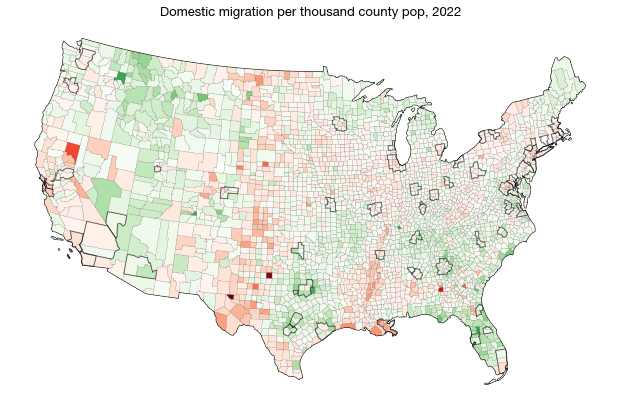

In [21]:
# plot domestic migration per thousand, with large cities outlined
fig,ax = plt.subplots(figsize=(14,7),nrows=1)
col = 'DOMMIG2022_THOU'

usa.plot(ax=ax,color='w',edgecolor='black')
metro_mask = gdf.urban_influence < 2

if abs(gdf[col].min()) > abs(gdf[col].max()):
    vmin,vmax=gdf[col].min(),-gdf[col].min()
else:
    vmin,vmax=-gdf[col].max(),gdf[col].max()

gdf[(gdf[col]>0)].plot(ax=ax,column=col,cmap='Greens',edgecolor='black',lw=.1,legend=False,vmax=vmax)
gdf[(gdf[col]<=0)].plot(ax=ax,column=col,cmap='Reds_r',edgecolor='black',lw=.1,legend=False,vmin=vmin)
cbsa_central = gdf[~(gdf.cbsa_title.isna())&(gdf.county_status=='central')]
cbsa_central[cbsa_central.urban_influence==1].dissolve(by='cbsa_title').plot(ax=ax,color='None',alpha=.5,edgecolor='black',lw=1)

mapspines(ax)
plt.title(label='Domestic migration per thousand county pop, 2022',
          fontproperties=prop,fontsize=13)
plt.show()

Clear evidence of a non-random spatial process. Large clusters indicate that I may want to use inverse distance weighting scheme to reach beyond contiguous neighbors.

In [22]:
# spatial weight matrix (drop null rows from df)
g = gdf.copy()
w_queen = ps.lib.weights.Queen.from_dataframe(g[[col,'geometry']].dropna(),silence_warnings=True)
w_queen.set_transform('R')

# compute spatial lag
y = g[[col,'geometry']].dropna()[col]
y_lag = ps.lib.weights.lag_spatial(w_queen, y)

# is a county's domestic migration rate similar to its neighbors?
col_lag = f'{col}_lag'
data_lag = pd.DataFrame(data={col:y, col_lag:y_lag}).astype(float)
data_lag.head()

,DOMMIG2022_THOU,DOMMIG2022_THOU_lag
FIPS,,
01001,8.500812,-1.464585
01003,28.332015,-0.286491
01005,9.835667,-5.773206
01007,-13.678709,-2.196251
01009,9.947574,6.498254


In [23]:
# calculate the Moran's I
mi = ps.explore.esda.Moran(data_lag[col], w_queen)
print(mi.I)
print(mi.p_sim)

0.4232303859202676
0.001


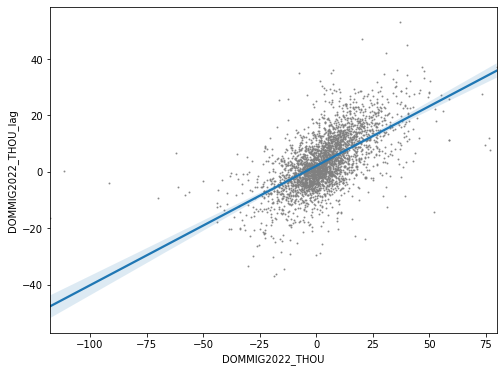

In [24]:
# Moran scatterplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(x=col, y=col_lag, data=data_lag, scatter_kws={'s':1, 'color':'gray'})
plt.show()

## Prep for regression
Want to use spatial lag and a variable reflecting distance from a large metro.

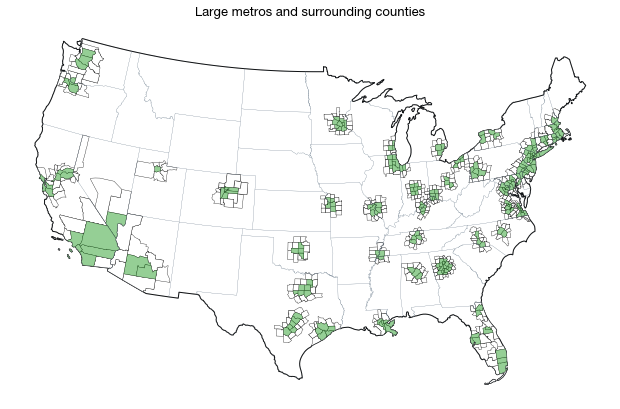

In [25]:
# plot large metros and use spatial join to grab surrounding counties
fig,ax = plt.subplots(figsize=(14,7),nrows=1)
usa.plot(ax=ax,color='w',edgecolor='black')

join_lg = gpd.sjoin(left_df=gdf,right_df=cbsa_central[(cbsa_central.urban_influence==1)][['geometry']],how='inner',op='intersects')
join_lg.plot(ax=ax,color='w',edgecolor='black',lw=.33)

cbsa_central[cbsa_central.urban_influence==1].plot(ax=ax,color='C2',alpha=.5,lw=0)
states.plot(ax=ax,color='None',edgecolor='slategray',lw=0.15)

mapspines(ax)
plt.title(label='Large metros and surrounding counties',fontproperties=prop,fontsize=13)
plt.show()

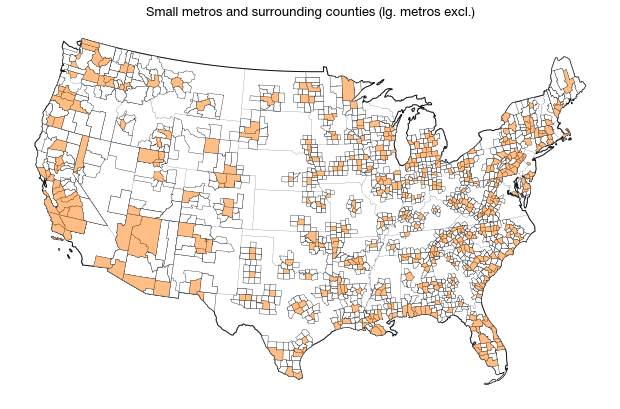

In [26]:
# plot SMALL metros and use spatial join to grab surrounding counties
cbsa_central = gdf[~(gdf.cbsa_title.isna())&(gdf.county_status=='central')]

fig,ax = plt.subplots(figsize=(14,7),nrows=1)
usa.plot(ax=ax,color='w',edgecolor='black')

join_sm = gpd.sjoin(left_df=gdf,right_df=cbsa_central[(cbsa_central.urban_influence==2)][['geometry']],how='inner',op='intersects')
join_sm[join_sm.urban_influence!=1].plot(ax=ax,color='w',edgecolor='black',lw=.33)

cbsa_central[cbsa_central.urban_influence==2].plot(ax=ax,color='C1',alpha=.5,edgecolor='black',lw=0)

states.plot(ax=ax,color='None',edgecolor='slategray',lw=0.15)

mapspines(ax)

plt.title(label='Small metros and surrounding counties (lg. metros excl.)',fontproperties=prop,fontsize=13)
plt.show()

In [27]:
# create new dummy variable for bordering large metro county (spatial regime 1)
gdf.loc[:,'borders_lgmet_d'] = 0
gdf.loc[join_lg[~(join_lg.urban_influence==1)].index,'borders_lgmet_d'] = 1

# create new dummy variable for bordering small metro county (spatial regime 2)
gdf.loc[:,'borders_smmet_d'] = 0
gdf.loc[join_sm[~(join_sm.urban_influence<3)].index,'borders_smmet_d'] = 1

# create dummy for large metro
gdf.loc[:,'lg_metro_d'] = 0
gdf.loc[(gdf.urban_influence==1)&(gdf.geo=='metro')&(gdf.county_status=='central'),'lg_metro_d'] = 1

# create dummy for small metro
gdf.loc[:,'sm_metro_d'] = 0
gdf.loc[(gdf.urban_influence==2)&(gdf.geo=='metro')&(gdf.county_status=='central'),'sm_metro_d'] = 1

# create dummy for outlying CBSA county status
gdf.loc[:,'outlying_d'] = 0
gdf.loc[(gdf.county_status=='central'),'outlying_d'] = 1

# create dummy for micro CBSA
gdf.loc[:,'micro_d'] = 0
gdf.loc[(gdf.geo=='micro')&(gdf.county_status=='central'),'micro_d'] = 1

In [28]:
# create table of domestic migration rate by geo and bordering lg metro by year
empty_list = []
for i in range(0,len(domestic_mig_cols)):
    empty_list.append((gdf.groupby(['geo','borders_lgmet_d'],dropna=False)[domestic_mig_cols[i]].sum() / \
                      (gdf.groupby(['geo','borders_lgmet_d'],dropna=False)[popestimate_cols[i]].sum() * .001)))
z = pd.concat(empty_list,axis=1)
z.columns = years
z.T

geo                 metro               micro                 NaN          
borders_lgmet_d         0         1         0         1         0         1
2010             0.022360  0.305174 -0.242442 -0.414756 -0.233507 -2.343369
2011             0.447829 -0.065781 -2.073025 -1.702163 -2.593603 -3.422853
2012             0.784255 -1.067008 -2.483465 -3.447858 -4.391489 -6.025749
2013             0.550100 -0.106220 -2.791304 -2.591960 -2.858724 -2.359114
2014             0.462027  0.940997 -2.767804 -1.807645 -3.023230 -2.206965
2015             0.340622  1.488925 -2.579457 -1.369199 -2.733557 -1.094688
2016             0.132430  2.630195 -2.394866  0.273148 -2.457475  1.076427
2017            -0.097702  3.073144 -1.790537  1.777244 -0.723995  3.206922
2018            -0.223817  3.000234 -1.101350  2.283890  0.069557  3.785396
2019            -0.161223  2.585232 -0.329825  1.848989 -0.923836  1.718350
2020            -0.071536  0.994463 -0.113182  0.658384  0.114816  0.638808
2021            -1.378657  5.465601  2.560446  5.841524  5.946073  9.198520
2022            -0.999033  4.591036  2.399724  3.897913  5.059026  5.907440

Dummies seem to show that metropolitan counties not-bordering large metros (including the metros themselves) are losing domestic pop., while counties bordering large metros are experiencign domestic migration inflows.

In [29]:
# create table of domestic and international migration rate by my new dummies
int_mig_cols = gdf.filter(regex='INTERNATIONAL').columns.tolist()

cols_lists = [domestic_mig_cols,int_mig_cols,popestimate_cols]
empty_list = []

lg_metro_mask = gdf.lg_metro_d==1
sm_metro_mask = gdf.sm_metro_d==1
micro_mask = gdf.geo=='micro'
central_mask = gdf.county_status=='central'
borders_lg_metro_mask = gdf.borders_lgmet_d==1
borders_sm_metro_mask = gdf.borders_smmet_d==1

for col_list in cols_lists:
    
    # lg metro
    a = gdf[lg_metro_mask & central_mask][col_list].sum().to_frame().T
    
    # sm metro
    b = gdf[sm_metro_mask & central_mask][col_list].sum().to_frame().T
    
    # borders lg metro (not lg or sm)
    c = gdf[~lg_metro_mask & ~sm_metro_mask & borders_lg_metro_mask][col_list].sum().to_frame().T
    
    # borders sm metro (not lg or sm)
    d = gdf[~lg_metro_mask & ~sm_metro_mask & borders_sm_metro_mask][col_list].sum().to_frame().T
    
    # borders nothing (not lg or sm)
    e = gdf[~lg_metro_mask & ~sm_metro_mask & ~borders_sm_metro_mask & ~borders_sm_metro_mask][col_list].sum().to_frame().T
    
    z = pd.concat([a,b,c,d,e])
    z.index = ['lg_metro','sm_metro','borders_lg_metro','borders_sm_metro','nonmet_&nonborder']
    empty_list.append(z)
    
z = pd.concat([(empty_list[0]/(empty_list[2]*.001).values), (empty_list[1]/(empty_list[2]*.001).values)],axis=1)
z = z.add_suffix('_per_1000')

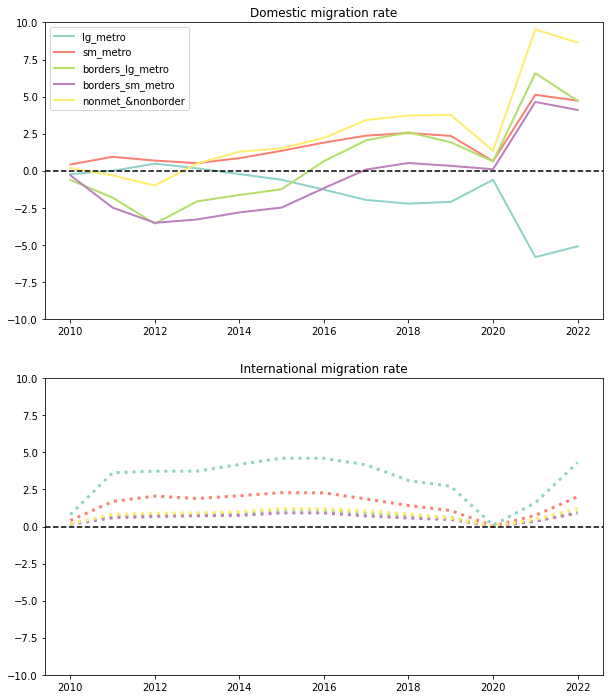

In [30]:
# graph domestic and international migration rates over time
fig,ax = plt.subplots(figsize=(10,12),nrows=2)
temp_df = z.filter(regex='DOM').T
temp_df.index=years
temp_df.plot(ax=ax[0],cmap='Set3',legend=True,lw=2)

ax[0].title.set_text('Domestic migration rate')
ax[0].axhline(y=0,color='black',ls='--',lw=1.5)
ax[0].set_ylim([-10, 10])

temp_df2 = z.filter(regex='INT').T
temp_df2.index=years
temp_df2.plot(ax=ax[1],ls=':',lw=3,cmap='Set3',legend=False,)

ax[1].axhline(y=0,color='black',ls='--',lw=1.5)
ax[1].title.set_text('International migration rate')
ax[1].set_ylim([-10, 10])
plt.show()

Large metros experienced domestic outflows beginning in 2013, but saw major decreases after the pandemic. Meanwhile the other regimes graphed seem to mirror large metropolitan declines, suggesting they are receiving these population flows.

International migration favors large metros and will likely never be negative, since international migrants are drawn to cities, become citizens, and then move on as domestic migrants. The dip in the pandemic reflects closed borders and blocked travel in 2020.

# Regression

In [31]:
# create log pop and log pop squared variables to accommodate likely diminishing returns on population size
gdf.loc[:,'log_pop_dens'] = np.log(gdf.POPESTIMATE2022 / (gdf.ALAND*10e-6))
gdf.loc[:,'log_pop_dens2'] = gdf.log_pop_dens**2

In [32]:
# load ACS 5yr DP data for covariates
key = 'd9b110204b6db43ea13ad3605d92060b8129450d'
c = Census(key)

census_vars = {'NAME':'name',
               'DP03_0062E'  : 'med_hh_inc',
               'DP05_0021PE' : 'pct_ov18',
               'DP05_0024PE' : 'pct_ov65',
               'DP02_0067PE' : 'pct_educ',
               'DP02_0092PE' : 'pct_fb',
               'DP05_0038PE' : 'pct_black',
               }

cen = c.acs5dp.state_county(fields = (list(census_vars.keys())),
                          state_fips = '*',
                          county_fips = '*',
                          year = 2020)

cen = pd.DataFrame(cen)
cen = cen[(cen.state!='72')&(cen.state!='15')&(cen.state!='02')]
cen = cen.set_index(cen.state + cen.county).drop(['state','county'],axis=1).sort_index()
cen.columns = cen.columns.map(census_vars)
cen.sample(5)

,name,med_hh_inc,pct_ov18,pct_ov65,pct_educ,pct_fb,pct_black
17101,"Lawrence County, Illinois",53087.0,81.1,17.5,85.0,37.8,9.6
29099,"Jefferson County, Missouri",67606.0,76.8,15.0,90.2,17.7,0.9
47045,"Dyer County, Tennessee",45042.0,76.2,17.5,85.7,24.6,12.4
27059,"Isanti County, Minnesota",76999.0,76.3,15.8,92.3,15.6,0.5
21125,"Laurel County, Kentucky",43745.0,76.9,16.3,81.5,20.3,0.6


In [33]:
# merge gdf and census data
rf = pd.concat([gdf,cen],axis=1)

# log transform median hh income
rf.loc[:,'log_med_hh_inc'] = np.log(rf.med_hh_inc)

rf.shape

(3108, 102)

In [34]:
# drop null rows
rf.dropna(subset=['DOMMIG2022_THOU','log_med_hh_inc','farm_d'],inplace=True)

# compute spatial weights without nulls
import libpysal
w_queen = libpysal.weights.Queen.from_dataframe(rf,silence_warnings=True)
w_queen.set_transform('R')

Y = rf.DOMMIG2022_THOU

# set explanatory variables
ind_cols = ['lg_metro_d','sm_metro_d','micro_d',
            'borders_lgmet_d','borders_smmet_d',
            'log_pop_dens', 'log_pop_dens2',
            #'log_med_hh_inc','mining_d','pct_educ','farm_d',
            'pct_ov65', 'pct_fb', 'pct_black',
            'manu_d', 'retire_d'
                                                                               ]

X = rf[ind_cols]

In [35]:
from spreg import OLS
ols = OLS(Y.values, X.values, w_queen, spat_diag=True, moran=True, robust='white',
          name_y=Y.name, name_x=X.columns.tolist(), name_ds='counties')
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :    counties
Weights matrix      :     unknown
Dependent Variable  :DOMMIG2022_THOU                Number of Observations:        3098
Mean dependent var  :      3.5077                Number of Variables   :          13
S.D. dependent var  :     14.3781                Degrees of Freedom    :        3085
R-squared           :      0.3004
Adjusted R-squared  :      0.2977
Sum squared residual:  447915.601                F-statistic           :    110.3891
Sigma-square        :     145.191                Prob(F-statistic)     :  8.666e-229
S.E. of regression  :      12.050                Log likelihood        :  -12100.362
Sigma-square ML     :     144.582                Akaike info criterion :   24226.725
S.E of regression ML:     12.0242                Schwarz criterion     :   24305.225

White Standard Errors
----------------------------------------------------

Model estimates
* Not a bad model fit: Adj R squared of 0.298
* Large metro county status negatively correlated, which was expected
* Primary hypothesis, that bordering a large metro area would be positively correlated with domestiv migration rate, was insignificant.
* Largest magnitude paramter: status as a retirement destination, which makes sense
* Paramter for quadratic log pop density negative and significant, indicating that pop density is only positively correlated with migration up until a certain point when it becomes a liabilty

Model diagnostics
* Moran's I of the residuals is 0.288 and significant, reflecting spatial dependence
* Lagrange multiplier tests for lag and error were both positive and significant
* Robust LM for spatial lag and error are also significant, but robust LM for error had low value and a larger p value
* Breusch-Pagan test positive and significant, reflecting heteroskedasticity—used White SEs to compensate

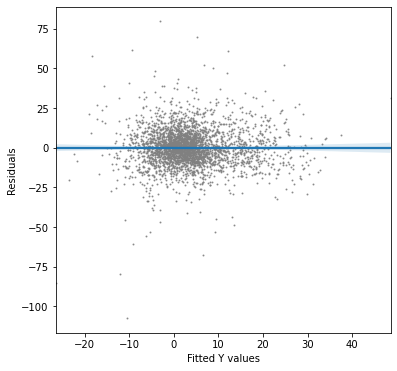

In [36]:
# grab residuals
res = list(map(list,list(ols.u)))
residuals = [item for sublist in res for item in sublist]

# Moran scatterplot
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(x=ols.predy, y=ols.u, scatter_kws={'s':1, 'color':'gray'})
ax.set(xlabel='Fitted Y values', ylabel='Residuals')
plt.show()

## Spatial Lag

In [37]:
# drop null rows
rf.dropna(subset=['DOMMIG2022_THOU','log_med_hh_inc','farm_d'],inplace=True)

# compute spatial weights without nulls
w_queen = libpysal.weights.Queen.from_dataframe(rf,silence_warnings=True)
w_idist = libpysal.weights.DistanceBand.from_dataframe(rf,threshold=10e4,binary=False,silence_warnings=True)
w_queen.set_transform('R')
w_idist.set_transform('R')

Y = rf.DOMMIG2022_THOU

# set explanatory variables
ind_cols = ['lg_metro_d','sm_metro_d','micro_d',
            #'borders_lgmet_d',
            'borders_smmet_d',
            'log_pop_dens', 'log_pop_dens2',
            'log_med_hh_inc',
            #'mining_d','pct_educ','farm_d',
            'pct_ov65', 'pct_fb', 'pct_black',
            'manu_d', 'retire_d'
                                                                               ]

X = rf[ind_cols]

In [38]:
from spreg import ML_Lag
mll = ML_Lag(Y.values, X.values, w_queen, method='full',
             name_y=Y.name, name_x=X.columns.to_list(), name_w='w_queen', name_ds='counties')
print(mll.summary)

/Users/marley/opt/miniconda3/envs/ppd599/lib/python3.9/site-packages/scipy/optimize/_minimize.py:779: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :    counties
Weights matrix      :     w_queen
Dependent Variable  :DOMMIG2022_THOU                Number of Observations:        3098
Mean dependent var  :      3.5077                Number of Variables   :          14
S.D. dependent var  :     14.3781                Degrees of Freedom    :        3084
Pseudo R-squared    :      0.4627
Spatial Pseudo R-squared:  0.3196
Sigma-square ML     :     111.598                Log likelihood        :  -11782.580
S.E of regression   :      10.564                Akaike info criterion :   23593.160
                                                 Schwarz criterion     :   23677.699

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------

In [39]:
from spreg import ML_Lag
mll = ML_Lag(Y.values, X.values, w_idist, method='full',
             name_y=Y.name, name_x=X.columns.to_list(), name_w='w_idist', name_ds='counties')
print(mll.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :    counties
Weights matrix      :     w_idist
Dependent Variable  :DOMMIG2022_THOU                Number of Observations:        3098
Mean dependent var  :      3.5077                Number of Variables   :          14
S.D. dependent var  :     14.3781                Degrees of Freedom    :        3084
Pseudo R-squared    :      0.4643
Spatial Pseudo R-squared:  0.3125
Sigma-square ML     :     111.060                Log likelihood        :  -11755.773
S.E of regression   :      10.538                Akaike info criterion :   23539.546
                                                 Schwarz criterion     :   23624.085

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------

Model results
* Better overall model fit
* Significant lagged outcome variable addresses unobserved heterogenity in previous model
* 'log_med_hh_inc' is now positive and significant
* Removed borders lg metro dummy since made no contribution to model fit
* all remaining variable parameters are significant

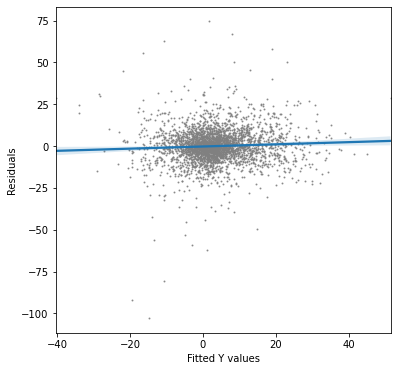

In [40]:
# grab residuals
res = list(map(list,list(mll.u)))
residuals = [item for sublist in res for item in sublist]

# Moran scatterplot
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(x=mll.predy, y=mll.u, scatter_kws={'s':1, 'color':'gray'})
ax.set(xlabel='Fitted Y values', ylabel='Residuals')
plt.show()

Slightly better correlation between fitted values and residuals.